In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [2]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std
from src.baseline.vocabulary import Vocabulary
from src.baseline.data_loader import get_loader, get_loaders, get_mean, get_std
from src.baseline.noise import Noise

import torch
import gc
# from GPUtil import showUtilization as gpu_usage


In [3]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'
caption_file = data_location + 'test_real_captions_psumsq.txt'


In [4]:

df = pd.read_csv(caption_file)
df

,image,caption,psum,psum_sq
0,6423_G A cross.jpg,G A cross,19754.472656,15046.065430
1,1739_A G cross patonce.jpg,A G cross patonce,18735.156250,14356.203125
2,2870_O S lion rampant.jpg,O S lion rampant,15362.364258,9554.638672
3,18746_S A eagle.jpg,S A eagle,13549.989258,9141.958984
4,29836_G O 3 eagles.jpg,G O 3 eagles,16778.851562,13274.360352
...,...,...,...,...
172,29394_G O eagle doubleheaded.jpg,G O eagle doubleheaded,15421.950195,11365.047852
173,398_A S lion rampant.jpg,A S lion rampant,18646.660156,14093.865234
174,4459_B O eagle.jpg,B O eagle,17065.537109,11514.578125
175,5302_O B cross moline.jpg,O B cross moline,18390.984375,13203.470703


In [5]:

train_annotation_file = data_location + '/train_captions_psumsq.txt'
val_annotation_file  = data_location + '/val_captions_psumsq.txt'
test_annotation_file  = data_location + '/test_captions_psumsq.txt'

# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))


There are 106 train images
There are 35 val images
There are 36 test images


In [6]:
images_location = data_location + '/resized'
NUM_WORKER = 2
BATCH_SIZE = 256
freq_threshold = 5

In [7]:
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11'}


In [8]:
images_location = data_location + '/resized'
NUM_WORKER = 2
BATCH_SIZE = 256
freq_threshold = 5

train_loader, train_dataset = get_loader(
    root_folder=images_location,
    annotation_file=train_annotation_file,
    transform=None, 
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    pin_memory=False,
    calc_mean=True
)


Caption: -1_G O eagle.jpg G O eagle 16743.310546875 11525.19921875
(93, 100, 3)


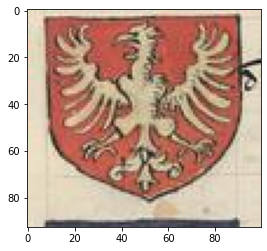

In [9]:
import matplotlib.image as mpimg
i = 17
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df1.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


In [13]:
mean = get_mean(train_dataset, train_loader, 100 , 100)
std = get_std(train_dataset, train_loader, mean, 100 , 100)

mean, std

(tensor(0.5654), tensor(0.2895))

In [ ]:
# mean,std = (torch.tensor(0.5654), torch.tensor(0.2895))
# mean,std

In [14]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std),
    Noise(0.1, 0.05)
])

In [18]:
dataiter = iter(train_loader)
images,classes,_,_,_ = next(dataiter)
images
# img = images[0]
# print(img)

# img = mpimg.imread(image_path)
# print(img.shape)
# # plt.imshow(img)
# plt.imshow(img.permute(1,2,0))
# plt.show()


tensor([])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is ',device)


device is  cuda


In [20]:
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(
    root_folder=images_location,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    device=device,
    pin_memory=False
)


initing train loader
-------------
initing val loader
-------------
initing test loader


## Visulize Real image which loaded using mean, std of same real train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 1293_O G lion rampant.jpg


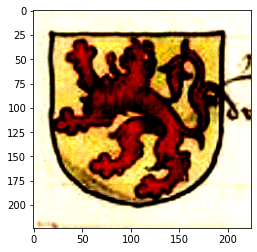

In [32]:
dataiter = iter(train_loader)
images,classes,_,_,image_paths = next(dataiter)

img = images[0]
image_path=image_paths[0]
print(img.shape, image_path)

plt.imshow(img.permute(1,2,0))


# Now trying with synthic mean and std

In [35]:
import matplotlib.image as mpimg

sdata_location = '/home/space/datasets/COA/generated-data-api-single' 

train_synthic_annotation_file = sdata_location + '/train_captions_psumsq.txt'
df_synthic = pd.read_csv(train_synthic_annotation_file)
df_synthic


,image,caption,psum,psum_sq
0,image_505.png,G A cross,9754.000000,7306.702148
1,image_466.png,O V cross patonce & border,9383.862305,6499.963867
2,image_4.png,A A lion passt & border,11961.236328,9800.056641
3,image_518.png,G O cross moline & border,8496.333984,5474.979004
4,image_422.png,B G cross moline & border,8296.243164,5130.335938
...,...,...,...,...
427,image_91.png,B S lion,7144.862793,4044.140137
428,image_350.png,V V lion & border,7522.916992,4321.125000
429,image_636.png,O S eagle & border,7614.454590,4677.295898
430,image_626.png,O A eagle doubleheaded & border,10646.416016,7832.498047


Caption: image_622.png B V eagle doubleheaded & border 7602.591796875 4378.6748046875
(100, 100, 4)


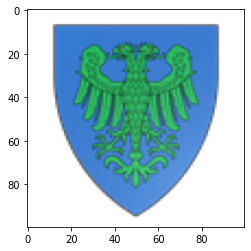

In [36]:
i = 58

simage_path = sdata_location + '/res_images/' + df_synthic.iloc[i,0]

image_path = images_location +'/'+ df_synthic.iloc[i,0]

print("Caption:", df_synthic.iloc[i,0], df_synthic.iloc[i,1], df_synthic.iloc[i,2],df_synthic.iloc[i,3])

simg=mpimg.imread(simage_path)
print(simg.shape)
plt.imshow(simg)
plt.show()


In [39]:
s_images_location = sdata_location + '/res_images'
NUM_WORKER = 2
BATCH_SIZE = 256
freq_threshold = 5

synth_train_loader, synth_train_dataset = get_loader(
    root_folder=s_images_location,
    annotation_file=train_synthic_annotation_file,
    transform=None, 
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    pin_memory=False,
    calc_mean=True
)


In [40]:
s_mean = get_mean(synth_train_dataset, synth_train_loader, 100 , 100)
s_std = get_std(synth_train_dataset, synth_train_loader, s_mean, 100 , 100)

s_mean, s_std

(tensor(0.2876), tensor(0.3329))

## Getting new loaders of real dataset with mean-std coming from synthetic data

In [41]:
synth_transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(s_mean, s_std),
    Noise(0.1, 0.05)
])

In [42]:
train_loader_with_synth, _, _, train_dataset_with_synth, _, _ = get_loaders(
    root_folder=images_location,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=synth_transform, # <--------------
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    device=device,
    pin_memory=False
)


initing train loader
-------------
initing val loader
-------------
initing test loader


## Visulize Real image which loaded using mean, std of same Synthetic Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 6610_O S lion rampant.jpg


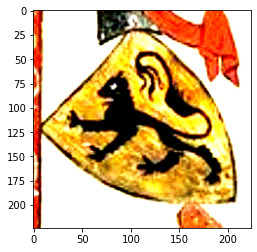

In [48]:
dataiter = iter(train_loader_with_synth)
images,classes,_,_,image_paths = next(dataiter)

img = images[0]
image_path=image_paths[0]
print(img.shape, image_path)

plt.imshow(img.permute(1,2,0))
